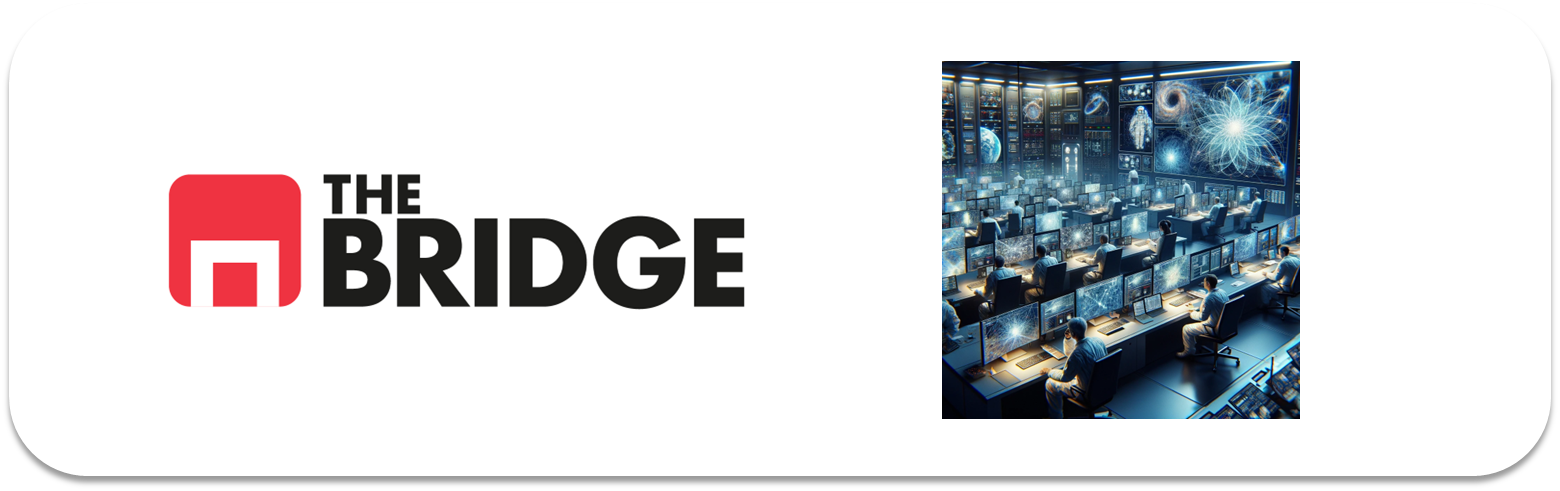

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



### *Construicción de una red convolucional ad-hoc*

In [106]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/seg_test/"


In [107]:
def read_data(directorio, reshape_dim = (75,75)):
    X = [] 
    y = []
    y_labels = []
    for i, folder in enumerate(os.listdir(directorio)):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = cv2.imread('/'.join([directorio, folder, file]))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(i)
                y_labels.append(folder)

    return np.array(X)/255, np.array(y), np.array(y_labels)

Cargamos los datos

In [108]:
X_train,y_train, y_train_labels = read_data(TRAIN_PATH)
X_test, y_test, y_test_labels = read_data(TEST_PATH) # Nota: podríamos dejar la creación de X_test para el final antes de usarlo y así ahorra memoria mientras no tengamos que emplearlo

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


Diccionarios para el mapeo, por si fuera necesario

In [109]:
class_dict = {label: i for i, label in enumerate(pd.Series(y_train_labels).unique())}
inverse_class_dict = {i:label for i, label in enumerate(pd.Series(y_train_labels).unique())}

In [110]:
class_dict

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [111]:
inverse_class_dict

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

Defino la función de visualización y veo algunas instancias:

In [112]:
class_names = list(class_dict.keys())
def show_images_batch(landscapes, n_cols, labels = [], names = class_names):
    n_rows = ((len(landscapes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    for index, cloth in enumerate(landscapes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cloth, cmap = "Greys")
        plt.axis("off")
        if len(labels):
            plt.title(names[labels[index]])

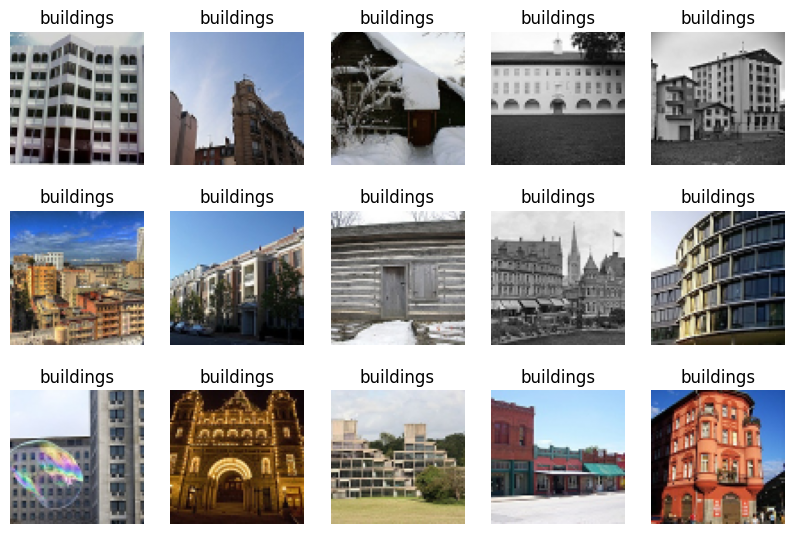

In [113]:
show_images_batch(X_train[315:330], 5, y_train[315:330])

Shuffleamos y visualizamos

In [114]:
from sklearn.utils import shuffle
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)

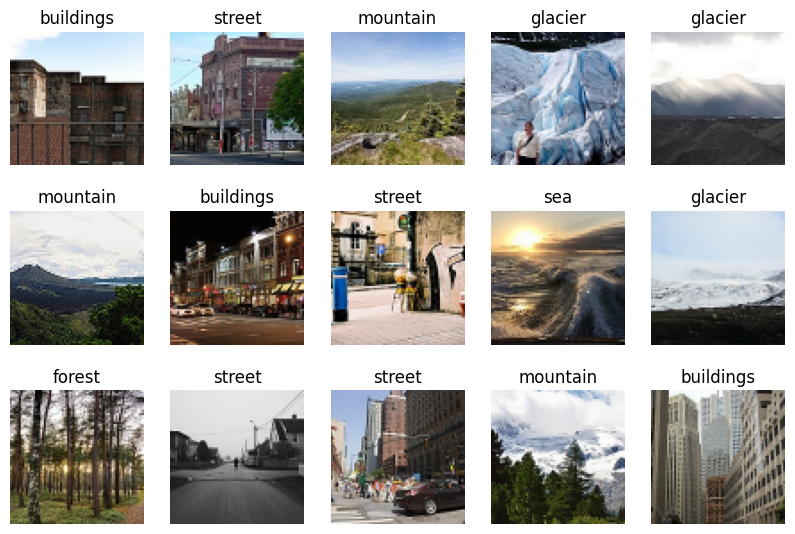

In [115]:
show_images_batch(X_train_shuffled[:15], 5, y_train_shuffled[:15])

### Target
(El escalado ya lo hago en la función para cargar los datos)

In [116]:
y_train_series = pd.Series(y_train)
y_train_series.value_counts(True)

3    0.178994
2    0.171298
5    0.169731
4    0.162035
1    0.161821
0    0.156121
Name: proportion, dtype: float64

Como ya sabíamos del otro ejercicio, el dataset está bastante balanceado

### Construcción de la red

In [117]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters = 64, kernel_size= (3, 3), padding= "same",
                              activation= "relu", input_shape = (X_train[0].shape)))
model.add(keras.layers.MaxPooling2D(pool_size= (2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters = 128, kernel_size= (3, 3), padding= "same",
                              activation= "relu"))
model.add(keras.layers.MaxPooling2D(pool_size= (2,2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(filters = 256, kernel_size= (3, 3), padding= "same",
                              activation= "relu"))
model.add(keras.layers.MaxPooling2D(pool_size= (2,2)))
model.add(keras.layers.Dropout(0.25))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation= "relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(6, activation= "softmax"))

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)


In [118]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience= 10,
                                                  restore_best_weights= 10)

history = model.fit(
    X_train_shuffled,
    y_train_shuffled,
    validation_split= 0.2,
    epochs= 100,
    callbacks = [early_stopping_cb]
)

Epoch 1/100
351/351 [==============================] - 163s 460ms/step - loss: 1.1432 - accuracy: 0.5471 - val_loss: 0.8887 - val_accuracy: 0.6573
Epoch 2/100
351/351 [==============================] - 173s 493ms/step - loss: 0.8412 - accuracy: 0.6824 - val_loss: 0.7262 - val_accuracy: 0.7271
Epoch 3/100
351/351 [==============================] - 170s 486ms/step - loss: 0.6896 - accuracy: 0.7488 - val_loss: 0.6456 - val_accuracy: 0.7599
Epoch 4/100
351/351 [==============================] - 171s 488ms/step - loss: 0.6010 - accuracy: 0.7829 - val_loss: 0.5832 - val_accuracy: 0.7937
Epoch 5/100
351/351 [==============================] - 176s 501ms/step - loss: 0.5289 - accuracy: 0.8075 - val_loss: 0.4945 - val_accuracy: 0.8140
Epoch 6/100
351/351 [==============================] - 158s 450ms/step - loss: 0.4891 - accuracy: 0.8215 - val_loss: 0.5877 - val_accuracy: 0.7909
Epoch 7/100
351/351 [==============================] - 143s 406ms/step - loss: 0.4309 - accuracy: 0.8450 - val_loss: 0

KeyboardInterrupt: 

### *Transfer learning con InceptionV3*

In [26]:
X_train_tl, y_train_tl, y_train_labels_tl = read_data(TRAIN_PATH, reshape_dim= (75, 75))
X_test_tl, y_test_tl, y_test_labels_tl = read_data(TEST_PATH, reshape_dim= (75, 75))

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [59]:
base_model_tl = keras.applications.InceptionV3(
    input_shape= (X_train_tl[0].shape),
    include_top= False,
    weights= "imagenet",
    classifier_activation= "softmax"
)

In [60]:
base_model_tl.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_285 (Conv2D)         (None, 37, 37, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 37, 37, 32)           96        ['conv2d_285[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 37, 37, 32)           0         ['batch_normalizati

In [61]:
for layer in base_model_tl.layers:
    layer.trainable = False

In [62]:
base_model_tl.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_285 (Conv2D)         (None, 37, 37, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 37, 37, 32)           96        ['conv2d_285[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 37, 37, 32)           0         ['batch_normalizati

In [63]:
x = keras.layers.Dropout(0.25)(base_model_tl.output)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation= "relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(6, activation= "softmax")(x)

model_tl = keras.models.Model(base_model_tl.input, x)

model_tl.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [64]:
model_tl.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_285 (Conv2D)         (None, 37, 37, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 37, 37, 32)           96        ['conv2d_285[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 37, 37, 32)           0         ['batch_normalization_28

In [65]:
X_train_tl_s, y_train_tl_s = shuffle(X_train_tl, y_train_tl)

In [66]:
history_tl = model_tl.fit(
    X_train_tl_s,
    y_train_tl_s,
    validation_split= 0.2,
    batch_size = 64,
    epochs = 100,
    callbacks = [early_stopping_cb]
)

Epoch 1/100
176/176 [==============================] - 38s 200ms/step - loss: 0.9490 - accuracy: 0.6516 - val_loss: 0.6782 - val_accuracy: 0.7520
Epoch 2/100
176/176 [==============================] - 32s 184ms/step - loss: 0.6834 - accuracy: 0.7420 - val_loss: 0.6304 - val_accuracy: 0.7684
Epoch 3/100
176/176 [==============================] - 36s 207ms/step - loss: 0.6060 - accuracy: 0.7689 - val_loss: 0.5949 - val_accuracy: 0.7752
Epoch 4/100
176/176 [==============================] - 37s 212ms/step - loss: 0.5594 - accuracy: 0.7914 - val_loss: 0.5876 - val_accuracy: 0.7827
Epoch 5/100
176/176 [==============================] - 41s 232ms/step - loss: 0.5232 - accuracy: 0.8036 - val_loss: 0.5853 - val_accuracy: 0.7741
Epoch 6/100
176/176 [==============================] - 41s 230ms/step - loss: 0.4796 - accuracy: 0.8156 - val_loss: 0.5743 - val_accuracy: 0.7862
Epoch 7/100
176/176 [==============================] - 33s 185ms/step - loss: 0.4343 - accuracy: 0.8378 - val_loss: 0.5805 -

### *Fine_Tuning del modelo completo con InceptionV3*

In [69]:
base_model_ft = keras.applications.InceptionV3(
    include_top= False,
    weights= None,
    input_shape= (X_train_tl[0].shape)
)

In [70]:
base_model_ft.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_379 (Conv2D)         (None, 37, 37, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 37, 37, 32)           96        ['conv2d_379[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 37, 37, 32)           0         ['batch_normalizati

In [71]:
x = keras.layers.Dropout(0.25)(base_model_ft.output)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation= "relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(6, activation= "softmax")(x)

model_ft = keras.models.Model(base_model_ft.input, x)

model_ft.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [73]:
history_ft = model_ft.fit(
    X_train_tl_s,
    y_train_tl_s,
    validation_split= 0.2,
    batch_size= 64,
    epochs = 20,
    callbacks = [early_stopping_cb]
)

Epoch 1/20
176/176 [==============================] - 179s 1s/step - loss: 0.4961 - accuracy: 0.8354 - val_loss: 0.5520 - val_accuracy: 0.8222
Epoch 2/20
176/176 [==============================] - 177s 1s/step - loss: 0.3711 - accuracy: 0.8745 - val_loss: 0.5977 - val_accuracy: 0.8026
Epoch 3/20
176/176 [==============================] - 152s 864ms/step - loss: 0.3519 - accuracy: 0.8852 - val_loss: 0.6784 - val_accuracy: 0.7788
Epoch 4/20
176/176 [==============================] - 164s 935ms/step - loss: 0.3577 - accuracy: 0.8814 - val_loss: 0.5906 - val_accuracy: 0.8051
Epoch 5/20
176/176 [==============================] - 166s 943ms/step - loss: 0.3174 - accuracy: 0.8928 - val_loss: 0.5954 - val_accuracy: 0.8190
Epoch 6/20
176/176 [==============================] - 160s 910ms/step - loss: 0.2740 - accuracy: 0.9102 - val_loss: 0.5858 - val_accuracy: 0.7952
Epoch 7/20
176/176 [==============================] - 163s 928ms/step - loss: 0.2441 - accuracy: 0.9180 - val_loss: 0.6791 - val_a

### *Evaluación de los tres modelos*

*Visualización de imágenes y probabilidades*

In [ ]:
def show_images_batch(landscapes, n_cols, labels = [], names = class_names):
    n_rows = ((len(landscapes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * 2, n_rows * 2.2))
    for index, cloth in enumerate(landscapes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cloth, cmap = "Greys")
        plt.axis("off")
        if len(labels):
            plt.title(names[labels[index]])

In [99]:
def plot_img_pred(X, y_true, y_pred, probs, class_names = list(class_dict.keys()), classes = list(class_dict.values())):
    n_rows = len(X) * 2
    n_cols = 1
    plt.figure(figsize = (6, n_rows * 2.2))
    for i, img in enumerate(X):
        plt.subplot(n_rows, 2* n_cols, 2*i + 1)
        plt.imshow(img)
        plt.title(class_names[y_true[i]])

        plt.subplot(n_rows, 2 * n_cols, 2*i + 2)
        sns.barplot(x = class_names, y = probs[i], hue = classes, palette = "tab10")
        plt.title(f"Probabilidad {class_names[y_pred[i]]}:  {probs[i][y_pred[i]]}, probabilidad {class_names[y_true[i]]}: {probs[i][y_true[i]]}")
        plt.tight_layout()
        plt.show();

##### ***CNN ad-hoc***

In [75]:
model.evaluate(X_test, y_test)

94/94 [==============================] - 1s 12ms/step - loss: 0.5372 - accuracy: 0.8197


[0.5372343063354492, 0.8196666836738586]

In [76]:
probabilities = model.predict(X_test)
y_pred = [np.argmax(prob) for prob in probabilities]

94/94 [==============================] - 1s 12ms/step


In [78]:
y_pred_labels = np.array([inverse_class_dict[pred] for pred in y_pred])

In [81]:
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.81      0.74      0.77       437
      forest       0.92      0.93      0.93       474
     glacier       0.78      0.79      0.78       553
    mountain       0.79      0.79      0.79       525
         sea       0.82      0.80      0.81       510
      street       0.81      0.88      0.84       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



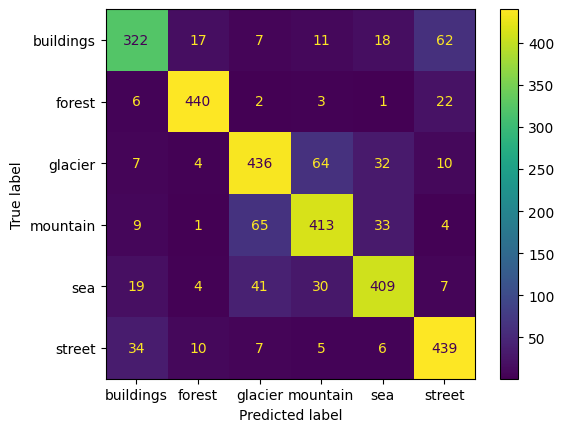

In [80]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(y_test_labels, y_pred_labels)

##### ***Transfer Learning InceptionV3***

In [82]:
model_tl.evaluate(X_test_tl, y_test_tl)

94/94 [==============================] - 8s 82ms/step - loss: 0.5884 - accuracy: 0.7850


[0.5883920788764954, 0.7850000262260437]

In [83]:
probabilities_tl = model_tl.predict(X_test_tl)
y_pred_tl = [np.argmax(prob) for prob in probabilities_tl]

94/94 [==============================] - 9s 84ms/step


In [84]:
y_pred_labels_tl = np.array([inverse_class_dict[pred] for pred in y_pred_tl])

In [85]:
print(classification_report(y_test_labels_tl, y_pred_labels_tl))

              precision    recall  f1-score   support

   buildings       0.83      0.81      0.82       437
      forest       0.94      0.94      0.94       474
     glacier       0.73      0.67      0.70       553
    mountain       0.65      0.73      0.69       525
         sea       0.75      0.78      0.77       510
      street       0.85      0.80      0.83       501

    accuracy                           0.79      3000
   macro avg       0.79      0.79      0.79      3000
weighted avg       0.79      0.79      0.79      3000



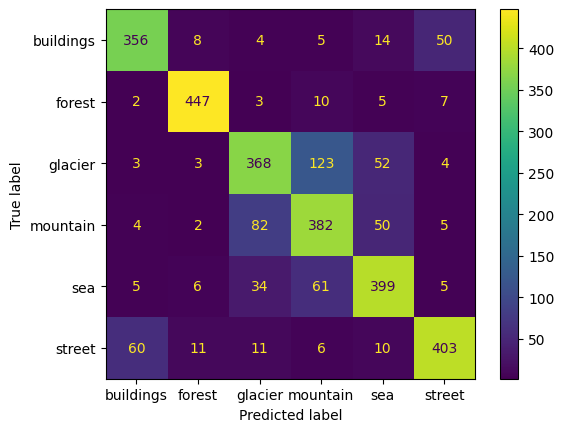

In [86]:
c_matrix.from_predictions(y_test_labels_tl, y_pred_labels_tl)

##### ***Fine-tuning InceptionV3***

In [87]:
model_ft.evaluate(X_test_tl, y_test_tl)

94/94 [==============================] - 7s 78ms/step - loss: 0.5149 - accuracy: 0.8383


[0.5148999691009521, 0.8383333086967468]

In [88]:
probabilities_ft = model_ft.predict(X_test_tl)
y_pred_ft = [np.argmax(prob) for prob in probabilities_ft]

94/94 [==============================] - 9s 88ms/step


In [89]:
y_pred_labels_ft = np.array([inverse_class_dict[pred] for pred in y_pred_ft])

In [90]:
print(classification_report(y_test_labels_tl, y_pred_labels_ft))

              precision    recall  f1-score   support

   buildings       0.85      0.80      0.82       437
      forest       0.90      0.96      0.93       474
     glacier       0.80      0.83      0.81       553
    mountain       0.85      0.73      0.78       525
         sea       0.79      0.88      0.83       510
      street       0.87      0.84      0.85       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



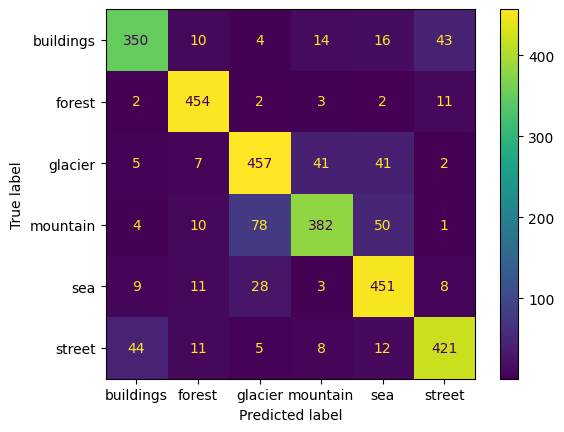

In [91]:
c_matrix.from_predictions(y_test_labels_tl, y_pred_labels_ft)

El que mejor resultado ha obtenido ha sido el modelo de fine-tuning, aunque no ha sido mucho mejor que la red convolucional creada ad hoc por mí, que parece que les ha ido bastante bien a estos datos, solo ha tenido un 82% menos de accuracy y el entrenamiento ha sido mucho más ligero. En general, los errores de los 3 modelos van en la misma dirección. Confunden bastate glacier y mountain entre sí (en ambas direcciones) y también con sea, aunque algo menos. Forest es la clase en la que menos se equivocan y también tienen problemas para diferencias entre street y building, que muchas veces no es culpa del modelo, sino de la imagen, ya que la línea entre una clase y otra es en ocasiones muy fina.